# 1.0 Housing Data Preparation – Utrecht Mobility Project


### 1. Project Overview

In this notebook, we gather, clean, and aggregate housing and jobs data from official Dutch sources. The data is sourced from the official Dutch government and statistical websites, including:

### 2. Data Sources
- **CBS (Centraal Bureau voor de Statistiek)**: [https://www.cbs.nl/](https://www.cbs.nl/)
- **PDOK (Publieke Dienstverlening Op de Kaart)**: [https://www.pdok.nl/](https://www.pdok.nl/)
- **Utrecht in Cijfers**: [https://utrecht.incijfers.nl/](https://utrecht.incijfers.nl/)

The goal is to preprocess and integrate this data for further analysis, focusing on housing growth and its geospatial distribution across neighborhoods in Utrecht. This includes:

1. **Data Gathering**: Importing raw housing and geospatial data.
2. **Data Cleaning**: Standardizing column names, handling missing values, and resolving mismatches between datasets.
3. **Data Aggregation**: Calculating growth metrics (absolute and percentage) and merging housing data with geospatial boundaries for visualization and analysis.

### 3. Load Raw Data

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
df_housing = pd.read_csv(
    "PATH_TO_HOUSING_CSV"
    sep=';'
)

In [4]:
df_housing.head()

,Buurten,totaal aantal woningen|2015,totaal aantal woningen|2016,totaal aantal woningen|2017,totaal aantal woningen|2018,totaal aantal woningen|2019,totaal aantal woningen|2020,totaal aantal woningen|2021,totaal aantal woningen|2022,totaal aantal woningen|2023,totaal aantal woningen|2024,totaal aantal woningen|2025,Totaal
0,"Welgelegen, Den Hommel",631,633,641,683,694,692,909,910,910,911,911,775
1,Oog in Al,1294,1381,1392,1428,1427,1427,1428,1428,1428,1428,1428,1408
2,Halve Maan-zuid,545,545,547,562,562,562,561,561,561,541,595,558
3,Halve Maan-noord,842,842,842,842,842,842,834,882,882,882,887,856
4,Lombok-oost,993,994,1015,1112,1111,1112,1092,1094,1101,1101,1101,1075


### 4. Clean & Standardize

In [5]:
# Clean column names
import re

df_housing.columns = df_housing.columns.str.strip()

# Build new column names: keep 'Buurten', drop 'Totaal', extract year if present
new_columns = []
for col in df_housing.columns:
    if col.lower() == 'buurten':
        new_columns.append('Buurten')
    elif re.search(r'20\d{2}', col):  # contains a year
        year = re.search(r'20\d{2}', col).group(0)
        new_columns.append(year)
    elif col.lower() == 'totaal':
        new_columns.append(None)  # mark for removal
    else:
        new_columns.append(col)  # fallback if something else is there

# Apply the cleaned column names (skip 'None' values)
columns_to_keep = [col for col in new_columns if col is not None]
df_housing.columns = new_columns
df_housing = df_housing[columns_to_keep]

# ✅ Check result
print("Cleaned columns:", df_housing.columns.tolist())


Cleaned columns: ['Buurten', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']


In [6]:
df_housing.head(112)

,Buurten,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,"Welgelegen, Den Hommel",631,633,641,683,694,692,909,910,910,911,911
1,Oog in Al,1294,1381,1392,1428,1427,1427,1428,1428,1428,1428,1428
2,Halve Maan-zuid,545,545,547,562,562,562,561,561,561,541,595
3,Halve Maan-noord,842,842,842,842,842,842,834,882,882,882,887
4,Lombok-oost,993,994,1015,1112,1111,1112,1092,1094,1101,1101,1101
...,...,...,...,...,...,...,...,...,...,...,...,...
107,De Meern-noord,1949,1949,1968,1998,2023,2072,2116,2118,2151,2225,2240
108,De Meern-zuid,2635,2635,2638,2640,2702,2703,2703,2704,2739,2739,2737
109,Oudenrijn,81,78,109,112,112,111,112,112,112,112,111
110,Rijnenburg,84,85,85,85,86,86,87,88,87,88,88


In [7]:
df_housing.to_csv("df_housing_cleaned.csv", index=False)

In [8]:
# Make sure 2015 and 2025 are numeric
df_housing['2015'] = pd.to_numeric(df_housing['2015'], errors='coerce')
df_housing['2025'] = pd.to_numeric(df_housing['2025'], errors='coerce')

# Absolute growth
df_housing['Absolute_Growth_2015_2025'] = df_housing['2025'] - df_housing['2015']

# Percentage growth
df_housing['Percentage_Growth_2015_2025'] = (
    (df_housing['2025'] - df_housing['2015']) / df_housing['2015'] * 100
).round(2)

# Done ✅
df_housing[['Buurten', '2015', '2025', 'Absolute_Growth_2015_2025', 'Percentage_Growth_2015_2025']].head()


,Buurten,2015,2025,Absolute_Growth_2015_2025,Percentage_Growth_2015_2025
0,"Welgelegen, Den Hommel",631,911,280,44.37
1,Oog in Al,1294,1428,134,10.36
2,Halve Maan-zuid,545,595,50,9.17
3,Halve Maan-noord,842,887,45,5.34
4,Lombok-oost,993,1101,108,10.88


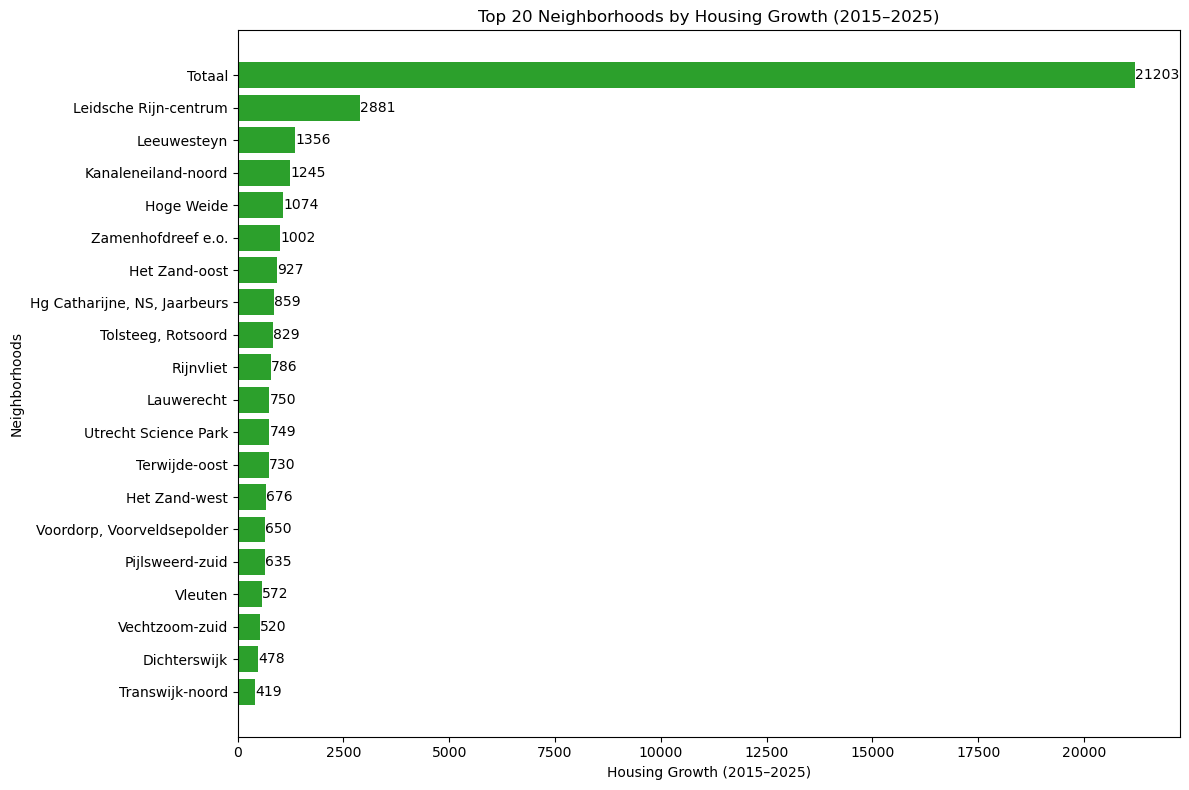

In [9]:
top20 = df_housing.sort_values(by='Absolute_Growth_2015_2025', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(
    top20['Buurten'],
    top20['Absolute_Growth_2015_2025'],
    color=['#2ca02c' if x >= 0 else '#d62728' for x in top20['Absolute_Growth_2015_2025']]
)

# Add labels with the total number per neighborhood
for bar, value in zip(bars, top20['Absolute_Growth_2015_2025']):
    plt.text(
        bar.get_width() + 5,  # Position slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically
        str(value),  # Text to display
        va='center',  # Vertical alignment
        fontsize=10  # Font size
    )

# Add titles and labels
plt.xlabel('Housing Growth (2015–2025)')
plt.ylabel('Neighborhoods')
plt.title('Top 20 Neighborhoods by Housing Growth (2015–2025)')
plt.gca().invert_yaxis()  # Biggest on top

# Show plot
plt.tight_layout()
plt.show()

### 5. Merge with Geometries

In [ ]:
import geopandas as gpd

gdf_buurten = gpd.read_file(
    "neighborhood_boundaries.gpkg"
gdf_buurten.head


In [12]:
# Normalize both columns for matching
df_housing['Buurten_clean'] = df_housing['Buurten'].str.lower().str.strip()
gdf_buurten['buurtnaam_clean'] = gdf_buurten['buurtnaam'].str.lower().str.strip()

# 🟥 Buurten in housing data not found in gdf_buurten
not_in_geo = df_housing[~df_housing['Buurten_clean'].isin(gdf_buurten['buurtnaam_clean'])]
print("🟥 In housing data but NOT in GeoDataFrame:")
print(not_in_geo['Buurten'].unique())

# 🟦 Buurten in gdf_buurten not found in housing data
not_in_housing = gdf_buurten[~gdf_buurten['buurtnaam_clean'].isin(df_housing['Buurten_clean'])]
print("\n🟦 In GeoDataFrame but NOT in housing data:")
print(not_in_housing['buurtnaam'].unique())

# ✅ Count matched
num_matched = df_housing['Buurten_clean'].isin(gdf_buurten['buurtnaam_clean']).sum()
num_total = len(df_housing)
print(f"\n✅ Matching buurten: {num_matched} / {num_total}")


🟥 In housing data but NOT in GeoDataFrame:
['Leidseweg' 'Ln v Nw-Guinea, Spinozaweg' 'Nw Engell, Th. à Kempisplts'
 'Bedrijvengebied Lage Weide' 'Nijenoord, Hoogstraat e.o.'
 '2e Daalsebuurt e.o.' 'Egelantierstr, Mariëndaalstr e.o.'
 'Julianapark e.o.' 'Elinkwijk e.o.' 'Pr.Bernhardpl e.o., Demkageb'
 'Geuzenwijk, De Driehoek' 'Schaakbuurt e.o.' 'Queeckhovenplein e.o.'
 'Taagdreef, Rubicondreef e.o.' 'Donaudreef, Wolgadreef e.o.'
 'Zamenhofdreef e.o.' 'Neckardreef e.o.' 'Bedrijvengebied Overvecht'
 'Zambesidreef e.o.' 'Tigrisdreef e.o.' 'Tuindorp, VanLieflandlaan-west'
 'Voordorp, Voorveldsepolder' 'Huizingalaan, K.Doormanlaan'
 'Zeeheldenbrt, Hengeveldstr. e.o.' 'Rubenslaan e.o.'
 'Lodewijk Napoleonplantsoen e.o.' 'Maarschalkerweerd, Mereveld'
 'Wilhelminapark e.o.' 'Galgenwaard e.o.'
 'L.Elisabethstr, Mariaplaats e.o' 'Hg Catharijne, NS, Jaarbeurs'
 'Breedstr, Plompetorengracht e.o' 'Nobelstraat e.o.'
 'Springweg e.o., Geertebrt' 'Lange Nieuwstraat e.o.' 'Bleekstraat e.o.'
 'Tolsteeg,

In [13]:
import unidecode

# Clean names in both DataFrames
def clean_name(name):
    if pd.isnull(name):
        return ""
    name = str(name).lower().strip()
    name = name.replace(".", "").replace(",", "")
    name = unidecode.unidecode(name)  # remove accents
    return name

df_housing["Buurten_clean"] = df_housing["Buurten"].apply(clean_name)
gdf_buurten["buurtnaam_clean"] = gdf_buurten["buurtnaam"].apply(clean_name)


In [14]:
# Find unmatched again
not_in_geo = df_housing[~df_housing['Buurten_clean'].isin(gdf_buurten['buurtnaam_clean'])]
print("🟥 In housing data but NOT in GeoDataFrame:")
print(not_in_geo['Buurten'].unique())

not_in_housing = gdf_buurten[~gdf_buurten['buurtnaam_clean'].isin(df_housing['Buurten_clean'])]
print("\n🟦 In GeoDataFrame but NOT in housing data:")
print(not_in_housing['buurtnaam'].unique())

# Count matches
num_matched = df_housing['Buurten_clean'].isin(gdf_buurten['buurtnaam_clean']).sum()
num_total = len(df_housing)
print(f"\n✅ Matching buurten: {num_matched} / {num_total}")


🟥 In housing data but NOT in GeoDataFrame:
['Leidseweg' 'Ln v Nw-Guinea, Spinozaweg' 'Nw Engell, Th. à Kempisplts'
 'Bedrijvengebied Lage Weide' 'Nijenoord, Hoogstraat e.o.'
 '2e Daalsebuurt e.o.' 'Egelantierstr, Mariëndaalstr e.o.'
 'Julianapark e.o.' 'Elinkwijk e.o.' 'Pr.Bernhardpl e.o., Demkageb'
 'Geuzenwijk, De Driehoek' 'Schaakbuurt e.o.' 'Queeckhovenplein e.o.'
 'Taagdreef, Rubicondreef e.o.' 'Donaudreef, Wolgadreef e.o.'
 'Zamenhofdreef e.o.' 'Neckardreef e.o.' 'Bedrijvengebied Overvecht'
 'Zambesidreef e.o.' 'Tigrisdreef e.o.' 'Tuindorp, VanLieflandlaan-west'
 'Voordorp, Voorveldsepolder' 'Huizingalaan, K.Doormanlaan'
 'Zeeheldenbrt, Hengeveldstr. e.o.' 'Rubenslaan e.o.'
 'Lodewijk Napoleonplantsoen e.o.' 'Maarschalkerweerd, Mereveld'
 'Wilhelminapark e.o.' 'Galgenwaard e.o.'
 'L.Elisabethstr, Mariaplaats e.o' 'Hg Catharijne, NS, Jaarbeurs'
 'Breedstr, Plompetorengracht e.o' 'Nobelstraat e.o.'
 'Springweg e.o., Geertebrt' 'Lange Nieuwstraat e.o.' 'Bleekstraat e.o.'
 'Tolsteeg,

In [15]:
import fiona

gpkg_path = "neighborhood_boundaries.gpkg"  # Path hidden for privacy
print(fiona.listlayers(gpkg_path))


['buurten', 'gemeenten', 'wijken']


In [16]:
gdf_buurten = gpd.read_file(gpkg_path, layer="buurten")


In [ ]:
import pandas as pd
import geopandas as gpd
import re
from fuzzywuzzy import process
import fiona

def clean_name(name):
    if pd.isnull(name): return ''
    name = name.lower()
    name = re.sub(r'\be\.?o\.?', '', name)
    name = re.sub(r'[^a-z0-9\s]', '', name)
    name = re.sub(r'\s+', ' ', name)
    return name.strip()

# -- Apply cleaning to housing
df_housing['buurt_clean'] = df_housing['Buurten'].apply(clean_name)

# -- List available layers in the GeoPackage
gpkg_path = "neighborhood_boundaries.gpkg"  # Path hidden for privacy
print("Available layers:", fiona.listlayers(gpkg_path))

# -- Load buurt geometries
gdf_buurten = gpd.read_file(gpkg_path, layer="buurten")

# FILTER: Keep only neighborhoods within the city of Utrecht
gdf_buurten = gdf_buurten[gdf_buurten['gemeentecode'] == 'GM0344'].copy()

# -- Clean buurt names
gdf_buurten['buurtnaam_clean'] = gdf_buurten['buurtnaam'].apply(clean_name)

# -- Identify unmatched names and do fuzzy matching
unmatched = df_housing[~df_housing['buurt_clean'].isin(gdf_buurten['buurtnaam_clean'])]
matched_names = []

for name in unmatched['buurt_clean']:
    match = process.extractOne(name, gdf_buurten['buurtnaam_clean'].tolist())
    if match[1] >= 85:
        matched_names.append((name, match[0]))

# -- Apply fuzzy match corrections
corrections = dict(matched_names)
df_housing['buurt_clean'] = df_housing['buurt_clean'].replace(corrections)


Available layers: ['buurten', 'gemeenten', 'wijken']


In [48]:
df_housing['buurt_clean'] = df_housing['buurt_clean'].replace(corrections)


In [49]:
# How many cleaned names match now?
matched = df_housing['buurt_clean'].isin(gdf_buurten['buurtnaam_clean'])
total = len(df_housing)
matches = matched.sum()
unmatched = total - matches

print(f"✅ Matching buurten: {matches} / {total} ({matches / total:.1%})")
print("🟥 Still unmatched:")
print(df_housing.loc[~matched, 'Buurten'].unique())


✅ Matching buurten: 102 / 111 (91.9%)
🟥 Still unmatched:
['Pr.Bernhardpl e.o., Demkageb' 'Taagdreef, Rubicondreef e.o.'
 'Donaudreef, Wolgadreef e.o.' 'Bedrijvengebied Overvecht'
 'Zeeheldenbrt, Hengeveldstr. e.o.' 'Lodewijk Napoleonplantsoen e.o.'
 'Bedr-geb. Strijkviertel' 'Bedr-geb. Papendorp'
 'Haarzuilens e.o./Parkweg-zuid']


In [50]:
print(df_housing.loc[~matched, 'buurt_clean'].unique())



['prbernhardpl demkageb' 'taagdreef rubicondreef' 'donaudreef wolgadreef'
 'bedrijvengebied overvecht' 'zeeheldenbrt hengeveldstr'
 'lodewijk napoleonplantsoen' 'bedrgeb strijkviertel' 'bedrgeb papendorp'
 'haarzuilens parkwegzuid']


In [62]:
final_manual_corrections = {
    "pr bernhardpl eo demkageb": "prins bernhardplein en omgeving",
    "taagdreef rubicondreef eo": "taag en rubicondreef en omgeving",
    "donaudreef wolgadreef eo": "wolga en donaudreef en omgeving",
    "bedrijvengebied overvecht": "bedrijventerrein en omgeving",
    "zeeheldenbrt hengeveldstr eo": "zeeheldenbuurt hengeveldstraat en omgeving",
    "lodewijk napoleonplantsoen eo": "l napoleonplantsoen en omgeving",
    "bedr geb strijkviertel": "bedrijvengebied strijkviertel",
    "bedr geb papendorp": "bedrijvengebied papendorp",
    "haarzuilens eo parkweg zuid": "haarzuilens en omgeving"
}

df_housing["buurt_clean"] = df_housing["buurt_clean"].replace(final_manual_corrections)



In [64]:
# Check again after manual fixes
matched = df_housing['buurt_clean'].isin(gdf_buurten['buurtnaam_clean'])
print(f"✅ Matching buurten: {matched.sum()} / {len(df_housing)} ({(matched.sum() / len(df_housing)) * 100:.1f}%)")

# Check if any remain unmatched
print("🟥 Still unmatched:")
print(df_housing[~matched]['Buurten'].unique())



✅ Matching buurten: 103 / 111 (92.8%)
🟥 Still unmatched:
['Pr.Bernhardpl e.o., Demkageb' 'Taagdreef, Rubicondreef e.o.'
 'Donaudreef, Wolgadreef e.o.' 'Zeeheldenbrt, Hengeveldstr. e.o.'
 'Lodewijk Napoleonplantsoen e.o.' 'Bedr-geb. Strijkviertel'
 'Bedr-geb. Papendorp' 'Haarzuilens e.o./Parkweg-zuid']


In [65]:
matched = df_housing['buurt_clean'].isin(gdf_buurten['buurtnaam_clean'])


In [66]:
gdf_buurten = gpd.read_file(gpkg_path, layer="buurten")
gdf_buurten = gdf_buurten[gdf_buurten["gemeentecode"] == "GM0344"].copy()
gdf_buurten["buurtnaam_clean"] = gdf_buurten["buurtnaam"].apply(clean_name)


In [67]:
# Show unmatched cleaned names from df_housing
unmatched_names = df_housing.loc[~matched, 'buurt_clean'].unique()
print("❌ Still unmatched (from df_housing):")
for name in unmatched_names:
    print("-", name)

# Print all gdf_buurten names (for comparison)
print("\n✅ Names available in gdf_buurten['buurtnaam_clean']:")
print(sorted(gdf_buurten['buurtnaam_clean'].unique()))


❌ Still unmatched (from df_housing):
- prbernhardpl demkageb
- taagdreef rubicondreef
- donaudreef wolgadreef
- zeeheldenbrt hengeveldstr
- lodewijk napoleonplantsoen
- bedrgeb strijkviertel
- bedrgeb papendorp
- haarzuilens parkwegzuid

✅ Names available in gdf_buurten['buurtnaam_clean']:
['2e daalsebuurt en omgeving', 'abstede tolsteegsingel', 'bedrijvengebied kanaleneiland', 'bedrijvengebied oudenrijn', 'bedrijvengebied papendorp', 'bedrijvengebied strijkviertel', 'bedrijventerrein de wetering', 'bedrijventerrein en omgeving', 'bedrijventerrein lageweide', 'bleekstraat en omgeving', 'bokkenbuurt', 'breedstraat en plompetorengracht en omgeving', 'buiten wittevrouwen', 'de meernnoord', 'de meernzuid', 'dichterswijk', 'domplein neude janskerkhof', 'egelantierstraat marindaalstraat', 'elinkwijk en omgeving', 'galgenwaard en omgeving', 'geuzenwijk', 'grauwaart', 'haarrijn', 'haarzuilens en omgeving', 'halve maannoord', 'halve maanzuid', 'het zandoost', 'het zandwest', 'hoge weide', 'hooc

In [68]:
final_fixes = {
    "prbernhardpl demkageb": "prins bernhardplein en omgeving",
    "taagdreef rubicondreef": "taag en rubicondreef en omgeving",
    "donaudreef wolgadreef": "wolga en donaudreef en omgeving",
    "zeeheldenbrt hengeveldstr": "zeeheldenbuurt hengeveldstraat en omgeving",
    "lodewijk napoleonplantsoen": "l napoleonplantsoen en omgeving",
    "bedrgeb strijkviertel": "bedrijvengebied strijkviertel",
    "bedrgeb papendorp": "bedrijvengebied papendorp",
    "haarzuilens parkwegzuid": "haarzuilens en omgeving"
}


In [69]:
df_housing["buurt_clean"] = df_housing["buurt_clean"].replace(final_fixes)


In [70]:
matched = df_housing['buurt_clean'].isin(gdf_buurten['buurtnaam_clean'])
print(f"✅ Matching buurten: {matched.sum()} / {len(df_housing)} ({(matched.sum() / len(df_housing)) * 100:.1f}%)")

unmatched_names = df_housing.loc[~matched, 'buurt_clean'].unique()
print("❌ Still unmatched:", unmatched_names)


✅ Matching buurten: 111 / 111 (100.0%)
❌ Still unmatched: []


In [73]:
df_housing = df_housing.rename(columns={"buurt_clean": "buurtnaam_clean"})


In [74]:
df_housing.head(110)

,Buurten,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,Absolute_Growth_2015_2025,Percentage_Growth_2015_2025,Buurten_clean,buurtnaam_clean,lon,lat,geometry
0,"Welgelegen, Den Hommel",631,633,641,683,694,692,909,910,910,911,911,280,44.37,welgelegen den hommel,welgelegen den hommel,NaN,NaN,MULTIPOLYGON (((135006.33889999986 455419.8880...
1,Oog in Al,1294,1381,1392,1428,1427,1427,1428,1428,1428,1428,1428,134,10.36,oog in al,oog in al,NaN,NaN,MULTIPOLYGON (((134605.71290000156 455754.2010...
2,Halve Maan-zuid,545,545,547,562,562,562,561,561,561,541,595,50,9.17,halve maan-zuid,halve maanzuid,NaN,NaN,MULTIPOLYGON (((134072.10090000182 455635.0560...
3,Halve Maan-noord,842,842,842,842,842,842,834,882,882,882,887,45,5.34,halve maan-noord,halve maannoord,NaN,NaN,MULTIPOLYGON (((133770.46599999815 456647.9560...
4,Lombok-oost,993,994,1015,1112,1111,1112,1092,1094,1101,1101,1101,108,10.88,lombok-oost,lombokoost,NaN,NaN,MULTIPOLYGON (((135822.95289999992 456037.5581...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Vleuterweide-zuid,1369,1407,1446,1511,1538,1562,1565,1575,1577,1577,1577,208,15.19,vleuterweide-zuid,vleuterweidezuid,NaN,NaN,MULTIPOLYGON (((128376.64689999819 456251.3711...
106,Veldhuizen,3408,3408,3412,3412,3413,3411,3412,3413,3412,3412,3412,4,0.12,veldhuizen,veldhuizen,NaN,NaN,MULTIPOLYGON (((129692.89990000054 455386.2780...
107,De Meern-noord,1949,1949,1968,1998,2023,2072,2116,2118,2151,2225,2240,291,14.93,de meern-noord,de meernnoord,NaN,NaN,MULTIPOLYGON (((130301.2479000017 456100.62079...
108,De Meern-zuid,2635,2635,2638,2640,2702,2703,2703,2704,2739,2739,2737,102,3.87,de meern-zuid,de meernzuid,NaN,NaN,MULTIPOLYGON (((130607.0439000018 455121.57899...


In [ ]:
df_housing.to_csv("exported_housing_data.csv", index=False)

In [ ]:
housing_geometry = df_housing.merge(
    gdf_buurten[['buurtnaam_clean', 'geometry']],
    on='buurtnaam_clean',
    how='left'
)
housing_geometry.head

In [86]:
# Drop the unnecessary/empty geometry_x column
housing_geometry = housing_geometry.drop(columns='geometry_x')

# Rename the correct geometry from gdf_buurten
housing_geometry = housing_geometry.rename(columns={'geometry_y': 'geometry'})

# Convert to a proper GeoDataFrame with that geometry
import geopandas as gpd
housing_geometry = gpd.GeoDataFrame(housing_geometry, geometry='geometry', crs='EPSG:28992')


In [87]:
print(housing_geometry.shape)
print(housing_geometry['geometry'].isna().sum())  # should be 0 if all matched


(111, 19)
0


## 7. Export Clean Dataset

In [89]:
housing_geometry.to_csv("housing_with_geometry.csv", index=False)

housing_geometry.to_file("housing_geometry.gpkg", layer="housing", driver="GPKG")
# or shapefile
housing_geometry.to_file("housing_geometry.shp")
